In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
url = 'https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv'

# Load the CSV file into a DataFrame
data = pd.read_csv(url)

# Get the column names as a list
column_names = data.columns.tolist()

# Create a copy of the DataFrame
data1 = data.copy()

In [4]:
MD=data.iloc[:,0:11].replace("Yes",1).replace("No",0)
mean=round(MD.mean(),2)
mean

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA()

# Fit the PCA model and transform the data
MD_pca = pca.fit_transform(MD)

# Fit the PCA model without transforming the data
MD_p = pca.fit(MD)

# Calculate the standard deviation of principal components
SD = np.sqrt(pca.explained_variance_)

# Calculate the proportion of variance explained by each principal component
PV = pca.explained_variance_ratio_

# Create index labels for the summary DataFrame
index = ["PC{}".format(i) for i in range(1, len(SD) + 1)]

# Create a summary DataFrame
summary = pd.DataFrame({
    "Standard Deviation": SD,
    "Proportion of Variance": PV,
    "Cumulative Proportion": PV.cumsum()
}, index=index)

# Display the summary DataFrame
print(summary)


      Standard Deviation  Proportion of Variance  Cumulative Proportion
PC1             0.757050                0.299447               0.299447
PC2             0.607456                0.192797               0.492244
PC3             0.504619                0.133045               0.625290
PC4             0.398799                0.083096               0.708386
PC5             0.337405                0.059481               0.767866
PC6             0.310275                0.050300               0.818166
PC7             0.289697                0.043849               0.862015
PC8             0.275122                0.039548               0.901563
PC9             0.265251                0.036761               0.938323
PC10            0.248842                0.032353               0.970677
PC11            0.236903                0.029323               1.000000


In [7]:
print("Standard Deviation:\n", SD.round(1))
load = (pca.components_)

Standard Deviation:
 [0.8 0.6 0.5 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2]


In [8]:
# Calculate the rotation matrix (transposed components)
rotation_matrix = -MD_p.components_.T

# Create a DataFrame for the rotation matrix
rotation_df = pd.DataFrame(rotation_matrix, index=MD.columns, columns=index)

# Round the values in the DataFrame to 3 decimal places
rotation_df = rotation_df.round(3)

# Display the rotation matrix DataFrame
print(rotation_df)

              PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9  \
yummy       0.477 -0.364  0.304 -0.055  0.308 -0.171  0.281 -0.013 -0.572   
convenient  0.155 -0.016  0.063  0.142 -0.278  0.348  0.060  0.113  0.018   
spicy       0.006 -0.019  0.037 -0.198 -0.071  0.355 -0.708 -0.376 -0.400   
fattening  -0.116  0.034  0.322  0.354  0.073  0.407  0.386 -0.590  0.161   
greasy     -0.304  0.064  0.802 -0.254 -0.361 -0.209 -0.036  0.138  0.003   
fast        0.108  0.087  0.065  0.097 -0.108  0.595  0.087  0.628 -0.166   
cheap       0.337  0.611  0.149 -0.119  0.129  0.103  0.040 -0.140 -0.076   
tasty       0.472 -0.307  0.287  0.003  0.211  0.077 -0.360  0.073  0.639   
expensive  -0.329 -0.601 -0.024 -0.068  0.003  0.261  0.068 -0.030 -0.067   
healthy     0.214 -0.077 -0.192 -0.763 -0.288  0.178  0.350 -0.176  0.186   
disgusting -0.375  0.140  0.089 -0.370  0.729  0.211  0.027  0.167  0.072   

             PC10   PC11  
yummy       0.110 -0.045  
convenient  0.666  0.

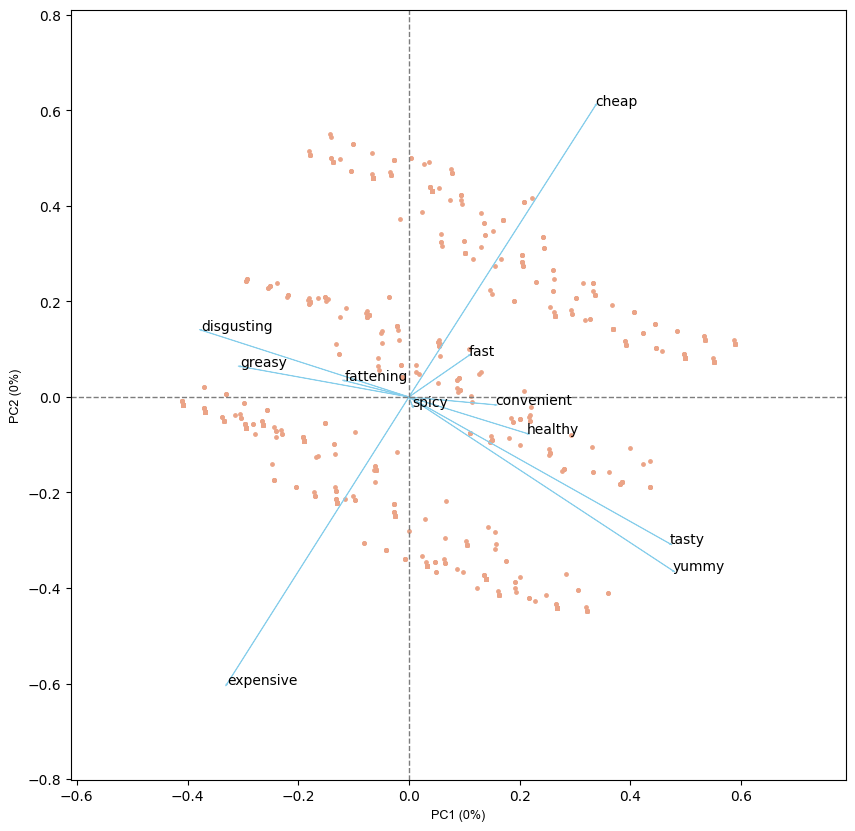

In [9]:
from bioinfokit.visuz import cluster

# Create a biplot using the given parameters
cluster.biplot(
    cscore=MD_pca,
    loadings=-load,
    labels=data.columns.values,
    var1=0,
    var2=0,
    show=True,
    dim=(10, 10)
)

In [10]:
np.random.seed(1234)

nrep = 10

num_segments = range(1, 9)
within_cluster_distances = []
MD_km = {}

for k in num_segments:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD)
    within_cluster_distances.append(kmeans.inertia_)
    MD_km[str(k)] = kmeans

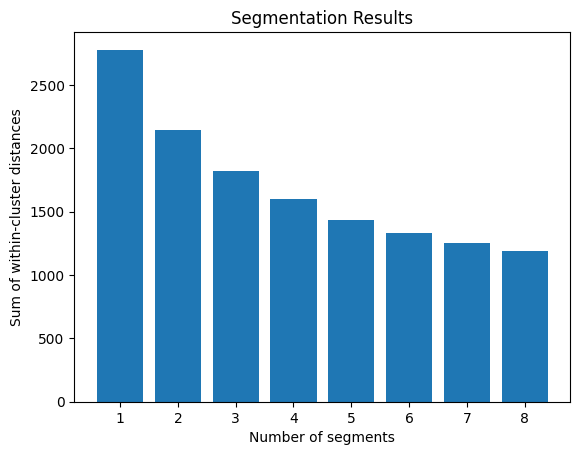

In [11]:
plt.bar(num_segments, within_cluster_distances)
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Segmentation Results")
plt.show()

In [12]:
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score

np.random.seed(1234)

nboot = 100
nrep = 10

bootstrap_samples = []
for _ in range(nboot):
    bootstrap_sample = resample(MD.values, random_state=1234)
    bootstrap_samples.append(bootstrap_sample)

adjusted_rand_index = []
num_segments = range(2, 9)
for k in num_segments:
    stability_scores = []
    for bootstrap_sample in bootstrap_samples:
        kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
        kmeans.fit(bootstrap_sample)
        cluster_labels = kmeans.predict(bootstrap_sample)
        true_labels = kmeans.predict(MD.values)
        stability_score = adjusted_rand_score(true_labels, cluster_labels)
        stability_scores.append(stability_score)
    adjusted_rand_index.append(stability_scores)

# Transpose the adjusted_rand_index list
adjusted_rand_index = np.array(adjusted_rand_index).T

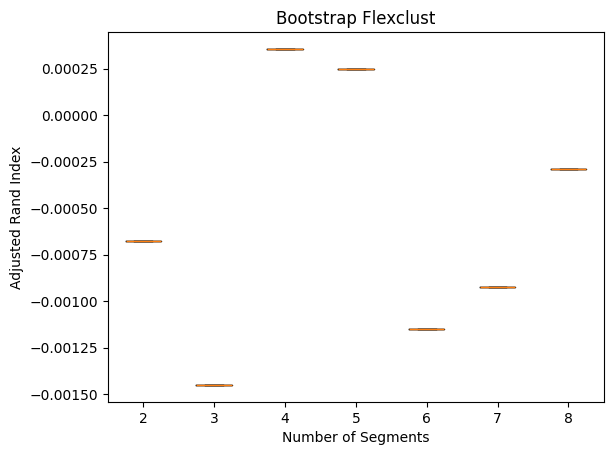

In [13]:
plt.boxplot(adjusted_rand_index, labels=num_segments, whis=10)
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Bootstrap Flexclust")
plt.show()

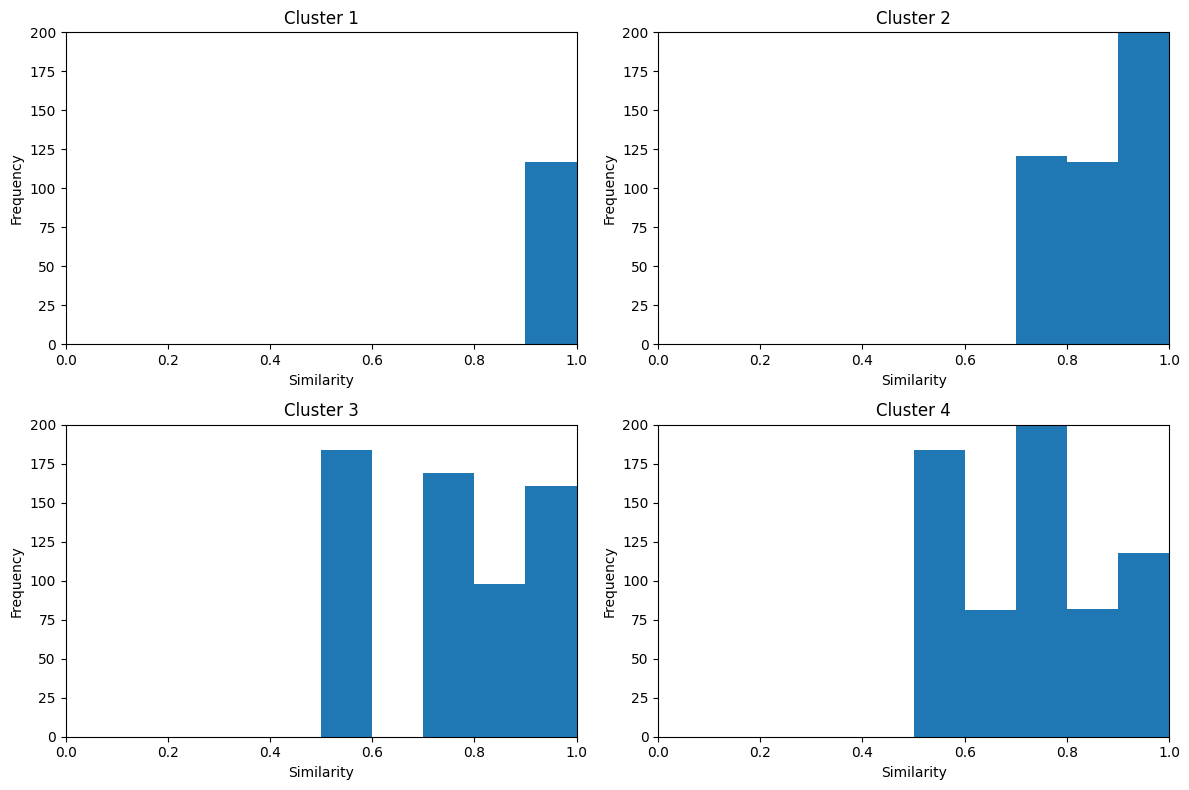

In [14]:
range_values = (0, 1)
num_bins = 10
max_frequency = 200

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(1, 5):
    labels = MD_km[str(i)].predict(MD)
    similarities = MD_km[str(i)].transform(MD).min(axis=1)
    row = (i - 1) // 2
    col = (i - 1) % 2

    ax = axs[row, col]
    ax.hist(similarities, bins=num_bins, range=range_values)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')
    ax.set_title('Cluster {}'.format(i))
    ax.set_xlim(range_values)
    ax.set_ylim(0, max_frequency)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.show()


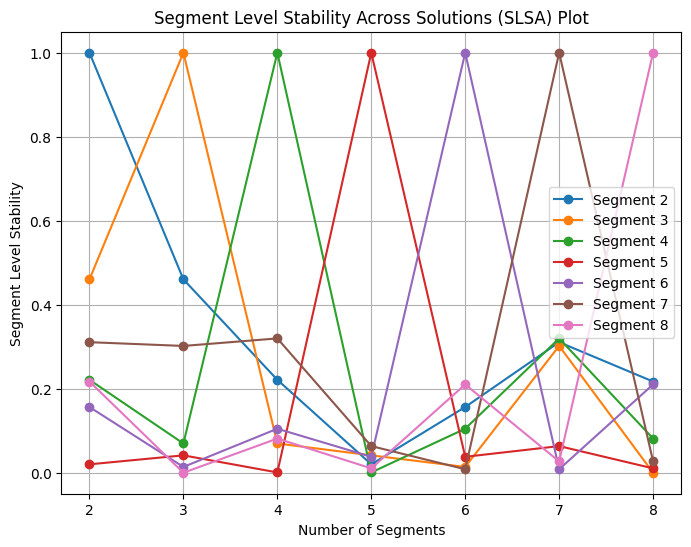

In [15]:
num_segments = range(2, 9)

segment_stability = []
for segment in num_segments:
    labels_segment = MD_km[str(segment)].predict(MD)
    segment_stability.append(labels_segment)

plt.figure(figsize=(8, 6))
for i, segment in enumerate(num_segments):
    stability_scores = [np.mean(segment_stability[i] == labels) for labels in segment_stability]
    plt.plot(num_segments, stability_scores, marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)

plt.show()


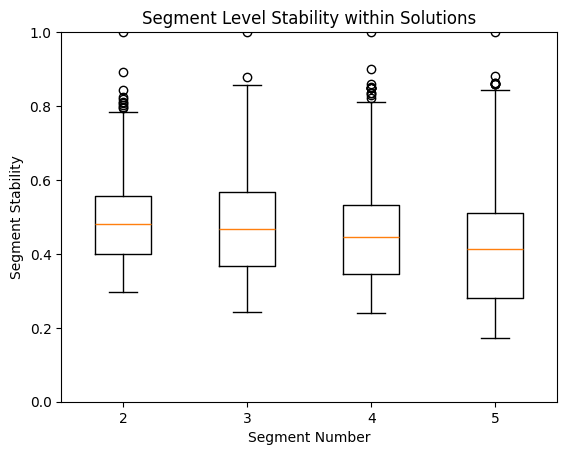

In [16]:
segment_solutions = ["2", "3", "4", "5"]
segment_labels = {}
segment_similarities = {}

for segment in segment_solutions:
    segment_labels[segment] = MD_km[segment].predict(MD)
    segment_similarities[segment] = MD_km[segment].transform(MD).min(axis=1)

segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)

plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")

plt.show()

In [17]:
from scipy.stats import entropy

np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD.values)
    iter_val = model.n_iter_
    converged = True  # Initially, assuming convergence
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy

    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))

MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)


d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-p

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0     8       True  2   2 -2145.503727  4295.007454  4305.570225  4304.904547
1     9       True  3   3 -1818.717659  3643.435318  3659.279475  3658.209672
2     7       True  4   4 -1602.986015  3213.972030  3235.097572  3233.753684
3    13       True  5   5 -1435.324786  2880.649571  2907.056500  2905.465473
4    10       True  6   6 -1332.150483  2676.300966  2707.989280  2706.201149
5    10       True  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6    10       True  8   8 -1191.580948  2399.161896  2441.412982  2439.379225


d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


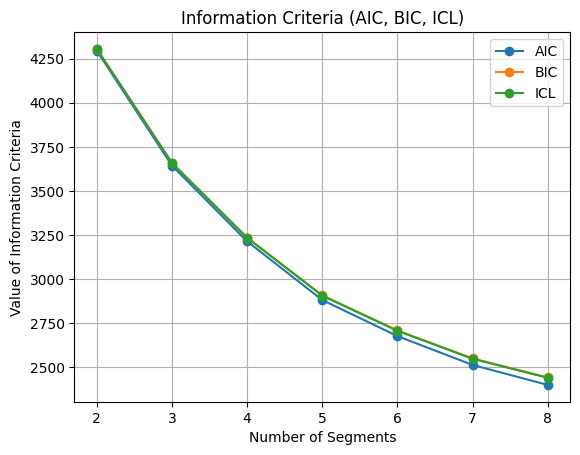

In [18]:
num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')

plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)

plt.show()

In [19]:
from sklearn.mixture import GaussianMixture

k = 4
kmeans = KMeans(n_clusters=k, random_state=1234)
kmeans.fit(MD)
kmeans_clusters = kmeans.predict(MD)

gmm = GaussianMixture(n_components=k, random_state=1234)
gmm.fit(MD)
gmm_clusters = gmm.predict(MD)

results = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': gmm_clusters})

MD_m4 = MD[results['mixture'] == 3]

k4_m4 = KMeans(n_clusters=k, random_state=1234)
k4_m4.fit(MD_m4)
k4_m4_clusters = k4_m4.predict(MD_m4)

results_m4 = pd.DataFrame({'kmeans': k4_m4_clusters, 'mixture': 3})

crosstab_kmeans_mixture = pd.crosstab(results['kmeans'], results['mixture'])
crosstab_kmeans_m4 = pd.crosstab(results['kmeans'], results_m4['kmeans'])

print("Cross-Tabulation for K-Means and Mixture:")
print(crosstab_kmeans_mixture)
print("\nCross-Tabulation for K-Means and Sub-cluster:")
print(crosstab_kmeans_m4)


Cross-Tabulation for K-Means and Mixture:
mixture    0    1    2    3
kmeans                     
0         99    5  253    7
1          0  211   24    5
2        500    0    0   33
3         22   38    0  256

Cross-Tabulation for K-Means and Sub-cluster:
kmeans   0   1   2   3
kmeans                
0       29  10  17  23
1       18   8  12  11
2       45  14  31  19
3       29   5  15  15


d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
gmm_m4a = GaussianMixture(n_components=4)
gmm_m4a.fit(MD)

log_likelihood_m4a = gmm_m4a.score(MD)

gmm_m4 = GaussianMixture(n_components=4)
gmm_m4.fit(MD)

log_likelihood_m4 = gmm_m4.score(MD)

print("Log-likelihood for MD.m4a:", log_likelihood_m4a)
print("Log-likelihood for MD.m4:", log_likelihood_m4)

Log-likelihood for MD.m4a: 9.456781748071885
Log-likelihood for MD.m4: 3.642746401176581


In [21]:
like_counts = pd.value_counts(data['Like'])
reversed_counts = like_counts.iloc[::-1]

print("Reversed Like Counts:")
print(reversed_counts)

Reversed Like Counts:
Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64


C:\Users\sreeh\AppData\Local\Temp\ipykernel_16028\2751195226.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  like_counts = pd.value_counts(data['Like'])


In [22]:
# Define a mapping of string values to numeric codes
like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

# Apply the mapping to create a new column 'Like.n'
data['Like.n'] = data['Like'].map(like_mapping)

# Count the occurrences of each numeric code
like_n_counts = data['Like.n'].value_counts()

# Print the counts
print("Like.n Value Counts:")
print(like_n_counts)

Like.n Value Counts:
Like.n
 0.0    169
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64


In [23]:
from patsy import dmatrices

# Select the independent variables from the first 11 columns
independent_vars = data.columns[:11]

# Create a formula string
formula_str = 'Like ~ ' + ' + '.join(independent_vars)

# Create the design matrix
f = dmatrices(formula_str, data=data)[1]

# Print the design matrix
print(f)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]]


In [24]:
from patsy import dmatrix

np.random.seed(1234)

# Create design matrix X and target variable y
X = dmatrix(f.design_info, data=data)
y = dmatrix('Like', data=data)

n_components = 2
n_init = 10
verbose = False
n_rep = 10

# Fit a Gaussian Mixture Model
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)
MD_reg2 = model.fit(X, y)

print("Gaussian Mixture Model:")
print(MD_reg2)

# Count the sizes of each cluster
cluster_sizes = np.bincount(model.predict(X))

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size}")

Gaussian Mixture Model:
GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
Cluster 1: 985
Cluster 2: 468


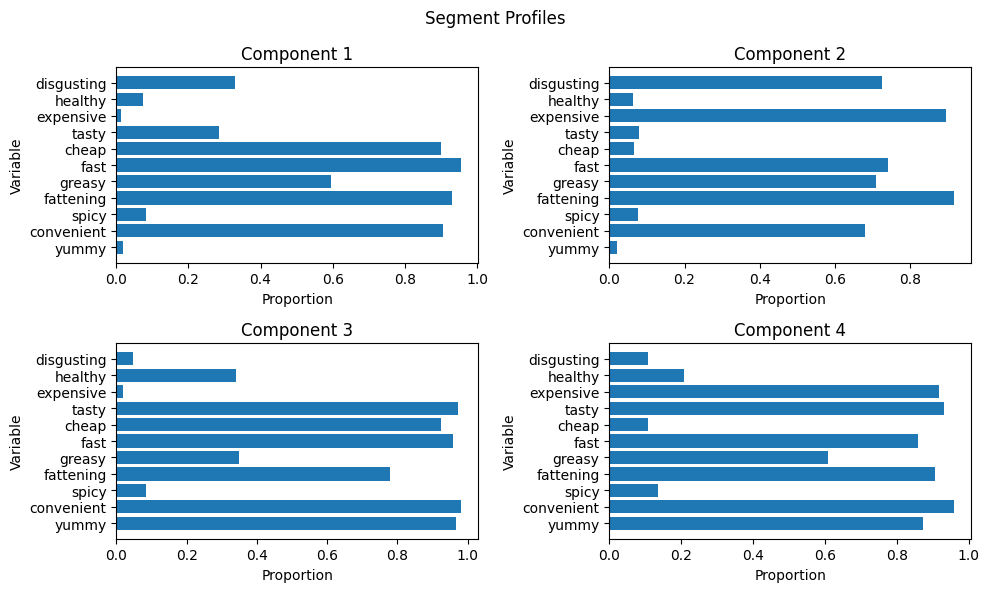

In [25]:
kmeans = MD_km['4']  # Use the correct variable name, assuming 'MD_km' is the K-means model
labels = kmeans.labels_
MD_mean = MD.groupby(labels).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.barh(range(MD_mean.shape[1]), MD_mean.iloc[i])
    ax.set_title(f'Component {i+1}')

for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD.columns)

fig.suptitle('Segment Profiles')
fig.tight_layout()
plt.show()

d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


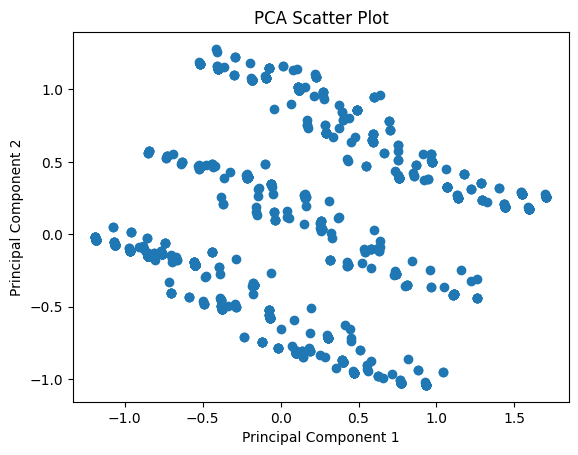

In [26]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(MD)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD)

fig, ax = plt.subplots()

ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Scatter Plot')

plt.show()


d:\Work\Feynn Labs\Projects\MY-WORK\CaseStudy-Fast-Food\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


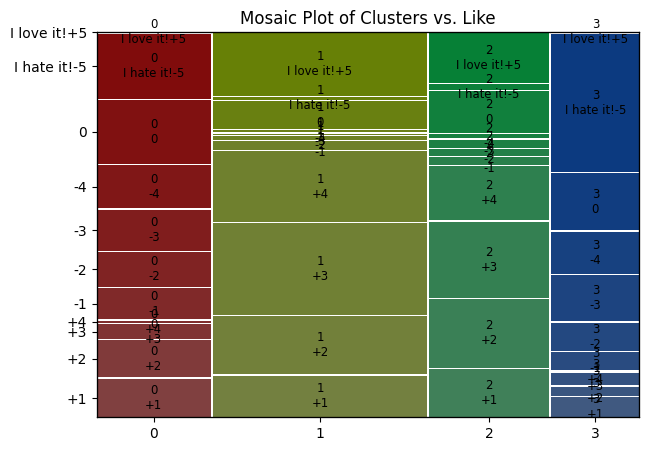

In [27]:
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.preprocessing import LabelEncoder

# Function for label encoding
def labelling(x, data):
    data[x] = LabelEncoder().fit_transform(data[x])
    return data

# Categorical columns to label encode
cat = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting']

for i in cat:
    data1 = labelling(i, data1)

df_eleven = data1.loc[:, cat]

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(df_eleven)
data1['cluster_num'] = kmeans.labels_

crosstab = pd.crosstab(data1['cluster_num'], data1['Like'])

plt.rcParams['figure.figsize'] = (7, 5)
mosaic(crosstab.stack())
plt.title("Mosaic Plot of Clusters vs. Like")
plt.show()


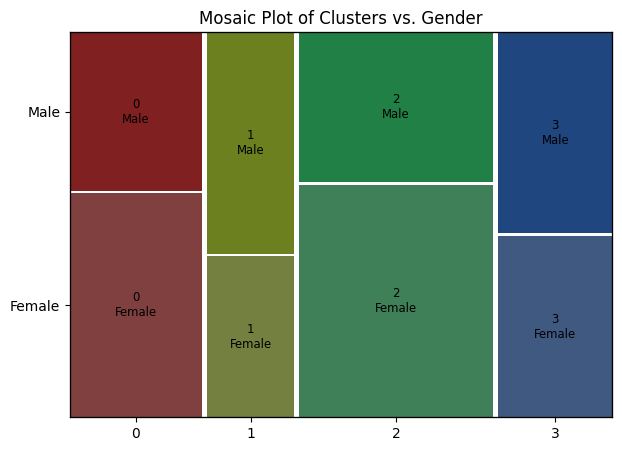

In [28]:
from statsmodels.graphics.mosaicplot import mosaic

MD_k4 = MD_km['4']  # Assuming MD_km is the correct variable name
k4 = MD_k4.labels_

ct = pd.crosstab(k4, data['Gender'])
mosaic(ct.stack(), gap=0.01)

plt.title("Mosaic Plot of Clusters vs. Gender")
plt.show()

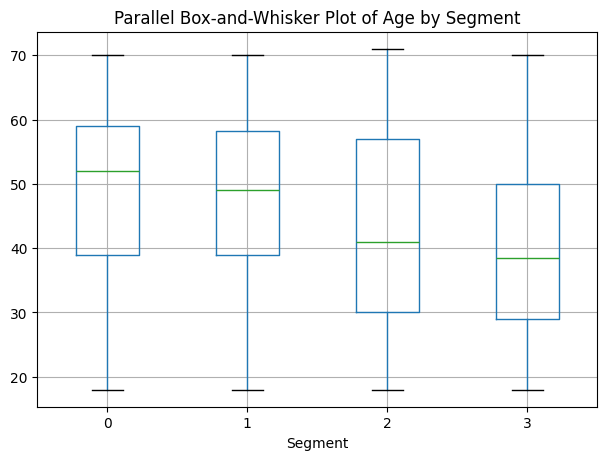

In [29]:
df = pd.DataFrame({'Segment': k4, 'Age': data['Age']})

df.boxplot(by='Segment', column='Age')
plt.title('Parallel Box-and-Whisker Plot of Age by Segment')
plt.suptitle('')
plt.show()

In [30]:
# Apply label encoding to 'VisitFrequency'
data1['VisitFrequency'] = LabelEncoder().fit_transform(data1['VisitFrequency'])

# Calculate the mean 'VisitFrequency' for each cluster
visit = data1.groupby('cluster_num')['VisitFrequency'].mean()
visit = visit.reset_index()

# Print the result
print(visit)

   cluster_num  VisitFrequency
0            0        2.809061
1            1        2.584483
2            2        2.540123
3            3        2.679167


In [31]:
# Apply label encoding to 'Like'
data1['Like'] = LabelEncoder().fit_transform(data1['Like'])

# Calculate the mean 'Like' for each cluster
Like = data1.groupby('cluster_num')['Like'].mean()
Like = Like.reset_index()

# Print the result
print(Like)

   cluster_num      Like
0            0  5.423948
1            1  3.794828
2            2  3.808642
3            3  6.775000


In [32]:
# Apply label encoding to 'Gender'
data1['Gender'] = LabelEncoder().fit_transform(data1['Gender'])

# Calculate the mean 'Gender' for each cluster
Gender = data1.groupby('cluster_num')['Gender'].mean()
Gender = Gender.reset_index()

# Print the result
print(Gender)

   cluster_num    Gender
0            0  0.407767
1            1  0.398276
2            2  0.521605
3            3  0.579167


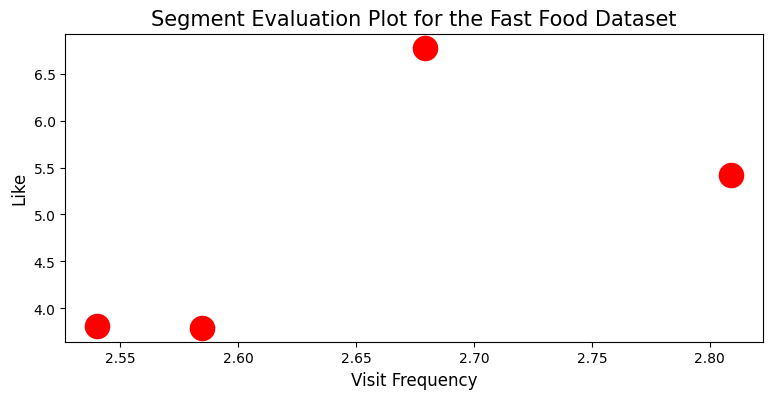

In [33]:
import seaborn as sns

# Merge the 'Gender,' 'Like,' and 'VisitFrequency' data for each cluster
segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')

plt.figure(figsize=(9, 4))
sns.scatterplot(x="VisitFrequency", y="Like", data=segment, s=400, color="r")
plt.title("Segment Evaluation Plot for the Fast Food Dataset", fontsize=15)
plt.xlabel("Visit Frequency", fontsize=12)
plt.ylabel("Like", fontsize=12)
plt.show()